# Tutorial 2 SPOTS

In this tutorial, we demonstrate how to use SCIGMA to analyze a Mouse Spleen SPOTS dataset. This tutorial can be run in under 5 minutes on a GPU-enabled computer.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from SCIGMA import *
from data import load_data, preprocessing
import numpy as np
import matplotlib.pyplot as plt
from utils import clustering
import scanpy as sc
import anndata
import xgboost as xgb

## Load and preprocess data

In [3]:
# SPOTS data
rna, pro = load_data()
rna

/users/schang59/anaconda/glue/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2653 × 32285
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [4]:
# preprocess into dict
data_dict = preprocessing(rna, pro, datatype='SPOTS', n_neighbors=6, feat_neighbors=6)

Preprocessing anndatas
Constructing spatial graphs
Constructing feature graphs
Feature graph 1
Feature graph 1 finished
Feature graph 2
Feature graph 2 finished


In [ ]:
rna.obsm['spatial'] = np.rot90(np.rot90(np.rot90(np.array(rna.obsm['spatial'])).T).T).T
rna.obsm['spatial'][:,1] = -1*rna.obsm['spatial'][:,1]

pro.obsm['spatial'] = np.rot90(np.rot90(np.rot90(np.array(pro.obsm['spatial'])).T).T).T
pro.obsm['spatial'][:,1] = -1*pro.obsm['spatial'][:,1]

connectivities1 = connectivity(np.where(data_dict['adata_omics1'].X>0, data_dict['adata_omics1'].X, 0), 1)
connectivities2 = connectivity(np.where(data_dict['adata_omics2'].X>0, data_dict['adata_omics2'].X, 0), 1)
connectivities = list(set(connectivities1).intersection(set(connectivities2)))

In [ ]:
# clear cache and initialize model
seed = 1303
model = SCIGMA(data_dict, seed_num=seed, device=torch.device('cuda:0'), dim_output=20, weight_decay=1e-2, batch_size = 2000, recon_weight1=1, recon_weight2=1, contrastive_weight1=1, contrastive_weight2=1, clr_weight=0.3, learning_rate=1e-3, downweight=0, connectivities=connectivities)

Num samples pruned: 2
Creating adjacency matrices
Model ready for training!


In [ ]:
# train
output = model.train(300)

In [12]:
adata_combined = data_dict['adata_omics1'].copy()
adata_combined.obsm['emb_latent_omics1'] = output['emb_latent_omics1']
adata_combined.obsm['emb_latent_omics2'] = output['emb_latent_omics2']
adata_combined.obsm['emb_latent_combined'] = output['emb_latent_combined']
adata_combined.obs['tau'] = output['tau']
adata_combined.obs['invtau'] = output['invtau']
adata_combined.obsm['attention'] = output['attention']

In [14]:
# we use mcluster as clustering tool by default.
tool = 'mclust' # mclust, leiden, and louvain

# clustering
if tool == 'mclust':
    clustering(adata_combined, key='emb_latent_combined', add_key='SCIGMA', n_clusters=6, method=tool, use_pca=False)
elif tool in ['leiden', 'louvain']:
    clustering(adata_combined, key='emb_latent_combined', add_key='SCIGMA', n_clusters=6, method=tool, start=0.1, end=2.0, increment=0.01)

fitting ...
  |======================================================================| 100%


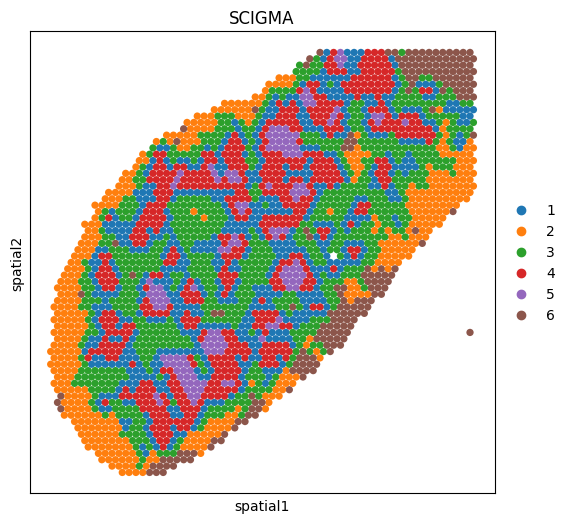

In [15]:
# visualization
fig, ax_list = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.embedding(adata_combined, basis='spatial', color='SCIGMA', ax=ax_list, title='SCIGMA', s=110, show=False)
plt.gca()
plt.show()

/users/schang59/anaconda/glue/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


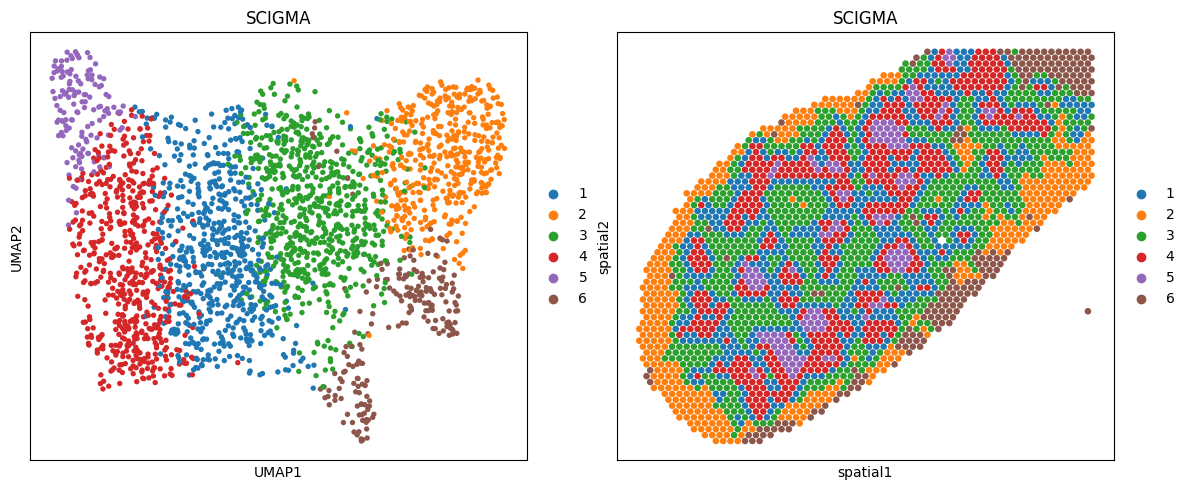

In [16]:
# visualization
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(adata_combined, use_rep='emb_latent_combined', n_neighbors=10)
sc.tl.umap(adata_combined)

sc.pl.umap(adata_combined, color='SCIGMA', ax=ax_list[0], title='SCIGMA', s=60, show=False)
sc.pl.embedding(adata_combined, basis='spatial', color='SCIGMA', ax=ax_list[1], title='SCIGMA', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

In [ ]:
# uncertainty visualization
fig, ax_list = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.embedding(adata_combined, 
                basis='spatial', 
                color=['invtau'], 
                title=['Uncertainty'], 
                ax=ax_list,
                s=50, show=False)
plt.gca()
plt.show()